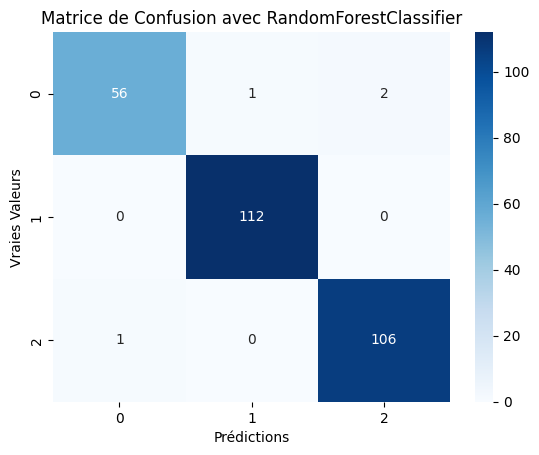

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        59
           1       0.99      1.00      1.00       112
           2       0.98      0.99      0.99       107

    accuracy                           0.99       278
   macro avg       0.99      0.98      0.98       278
weighted avg       0.99      0.99      0.99       278

Précision moyenne avec Cross Validation : 97.39%
Top 5 des caractéristiques importantes :
['ga', 'gf', 'xga', 'xg', 'sot']


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Importer le nouveau classificateur
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold


# Chargement des données
data = pd.read_csv('matches.csv')

# Supprimer les colonnes non pertinentes ou non numériques
colonnes_a_supprimer = ['Unnamed: 0', 'notes', 'time', 'comp', 'round', 'day', 'captain', 'formation', 'referee', 'match report']
data = data.drop(columns=colonnes_a_supprimer)

# Traitement des valeurs manquantes
data['attendance'] = data['attendance'].fillna(0)
data['dist'] = data['dist'].fillna(data['dist'].mean())

# Normalisation des colonnes numériques
colonnes_numeriques = ['gf', 'ga', 'xg', 'xga', 'poss', 'attendance', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
normaliseur = MinMaxScaler(feature_range=(1, 2))
data[colonnes_numeriques] = normaliseur.fit_transform(data[colonnes_numeriques])

# Encodage des variables catégorielles
label_encoder = LabelEncoder()
data['result'] = label_encoder.fit_transform(data['result'])

# Conversion de la colonne 'date' en format datetime et extraction des composants
data['date'] = pd.to_datetime(data['date'])
data['annee'] = data['date'].dt.year
data['mois'] = data['date'].dt.month
data['jour'] = data['date'].dt.day

# Préparation des données pour le modèle
X = data.drop(columns=['result', 'date'])
y = data['result']

# Identifier et encoder les autres colonnes catégorielles
colonnes_categorielles = X.select_dtypes(include=['object']).columns
for col in colonnes_categorielles:
    X[col] = label_encoder.fit_transform(X[col])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du nouveau modèle avec RandomForestClassifier
modele_classification = RandomForestClassifier()  # Utiliser RandomForestClassifier au lieu de LogisticRegression
modele_classification.fit(X_train, y_train)

# Faire des prédictions et évaluer le nouveau modèle
predictions = modele_classification.predict(X_test)
matrice_confusion = confusion_matrix(y_test, predictions)
sns.heatmap(matrice_confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.title('Matrice de Confusion avec RandomForestClassifier')
plt.show()
print(classification_report(y_test, predictions))




# Évaluation du modèle avec Cross Validation
scores = cross_val_score(modele_classification, X_train, y_train, cv=5)
print("Précision moyenne avec Cross Validation : {:.2f}%".format(scores.mean() * 100))

# Sélection des features avec RandomForest
importances = modele_classification.feature_importances_
indices = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
top_features = [X.columns[i] for i in indices[:5]]  # Choisissez le nombre de features à afficher
print("Top 5 des caractéristiques importantes :")
print(top_features)

# Ajustement (tuning) des hyperparamètres avec GridSearchCV
parametres_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametres_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(X_train, y_train)










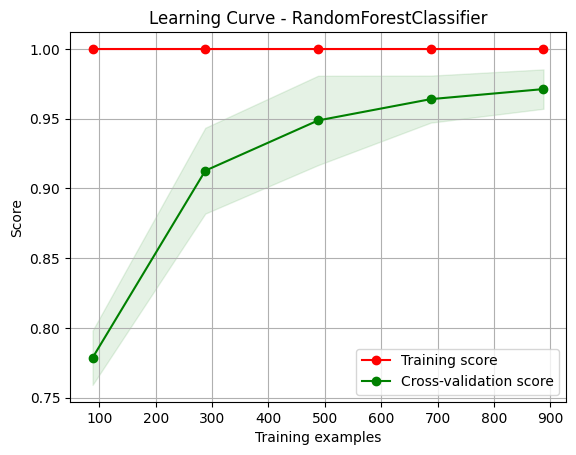

In [8]:
from sklearn.model_selection import learning_curve
import numpy as np
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(modele_classification, "Learning Curve - RandomForestClassifier", X_train, y_train, cv=5)
plt.show()